In [1]:
%matplotlib notebook
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>


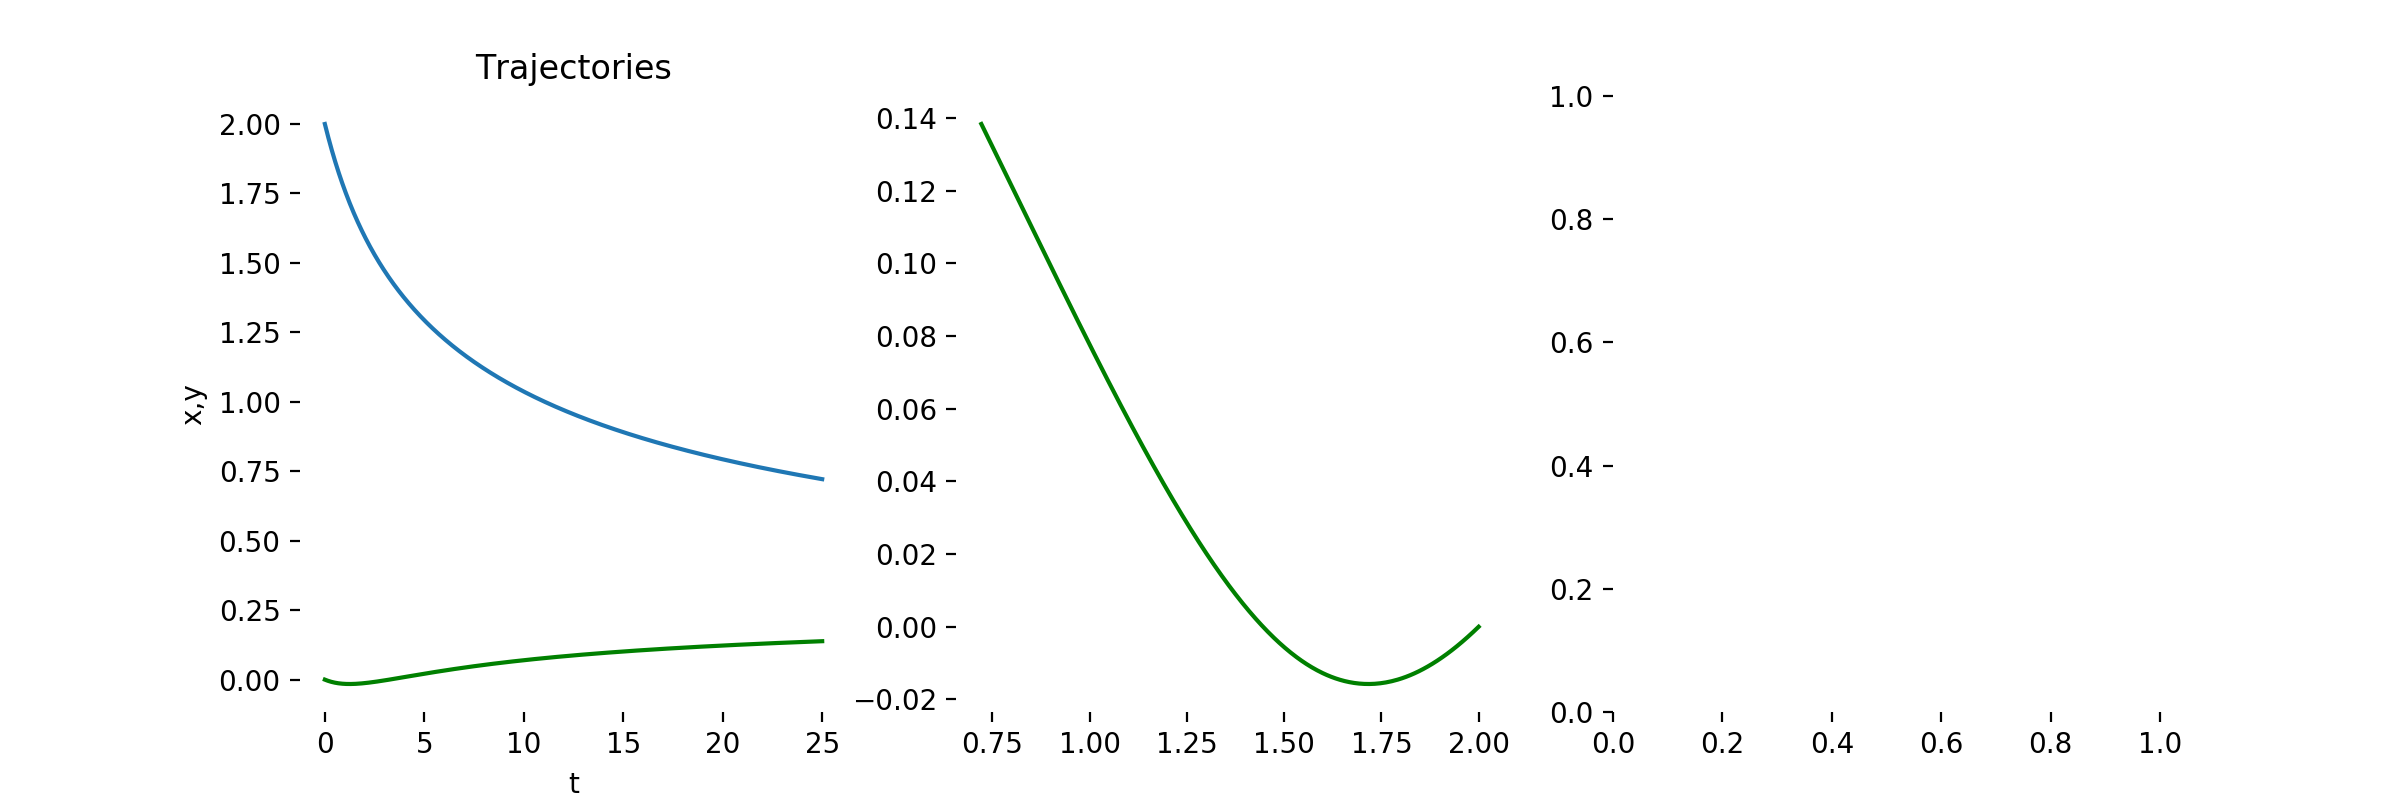

In [2]:
fig = plt.figure(figsize=(12, 4), facecolor='white')
ax_traj = fig.add_subplot(131, frameon=False)
ax_phase = fig.add_subplot(132, frameon=False)
ax_vecfield = fig.add_subplot(133, frameon=False)
plt.show(block=False)

In [32]:
class Lambda(nn.Module):
    def __init__(self):
        super(Lambda, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(2, 50),
            nn.Tanh(),
            nn.Linear(50, 2),
        )

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)
    def forward(self, t, y):
        return self.net(y**3)

In [33]:
true_y0 = torch.tensor([[2., 0.]])
t = torch.linspace(0., 25., 1000)
true_A = torch.tensor([[-0.1, 2.0], [-2.0, -0.1]])

In [34]:
with torch.no_grad():
    true_y = odeint(Lambda(), true_y0, t, method='dopri5')

In [47]:

def visualize(true_y, pred_y, odefunc, itr):
        ax_traj.cla()
        ax_traj.set_title('Trajectories')
        ax_traj.set_xlabel('t')
        ax_traj.set_ylabel('x,y')
        ax_traj.plot(t.numpy(), true_y.numpy()[:, 0, 0], t.numpy(), true_y.numpy()[:, 0, 1], 'g-')
        ax_traj.plot(t.numpy(), pred_y.numpy()[:, 0, 0], '--', t.numpy(), pred_y.numpy()[:, 0, 1], 'b--')
        ax_traj.set_xlim(t.min(), t.max())
        ax_traj.set_ylim(-2, 2)
        ax_traj.legend()

        ax_phase.cla()
        ax_phase.set_title('Phase Portrait')
        ax_phase.set_xlabel('x')
        ax_phase.set_ylabel('y')
        ax_phase.plot(true_y.numpy()[:, 0, 0], true_y.numpy()[:, 0, 1], 'g-')
        ax_phase.plot(pred_y.numpy()[:, 0, 0], pred_y.numpy()[:, 0, 1], 'b--')
        ax_phase.set_xlim(-2, 2)
        ax_phase.set_ylim(-2, 2)

        ax_vecfield.cla()
        ax_vecfield.set_title('Learned Vector Field')
        ax_vecfield.set_xlabel('x')
        ax_vecfield.set_ylabel('y')

        y, x = np.mgrid[-2:2:21j, -2:2:21j]
        dydt = odefunc(0, torch.Tensor(np.stack([x, y], -1).reshape(21 * 21, 2))).cpu().detach().numpy()
        mag = np.sqrt(dydt[:, 0]**2 + dydt[:, 1]**2).reshape(-1, 1)
        dydt = (dydt / mag)
        dydt = dydt.reshape(21, 21, 2)

        ax_vecfield.streamplot(x, y, dydt[:, :, 0], dydt[:, :, 1], color="black")
        ax_vecfield.set_xlim(-2, 2)
        ax_vecfield.set_ylim(-2, 2)

        fig.tight_layout()
        plt.savefig('png/{:03d}'.format(itr))
        plt.draw()
        plt.pause(0.001)

In [50]:
visualize(true_y,pred_y,dudt_train,3)

RuntimeError: Can't call numpy() on Variable that requires grad. Use var.detach().numpy() instead.

In [36]:
def get_batch(batch_time=10,data_size=1000,batch_size=20):
    s = torch.from_numpy(np.random.choice(np.arange(data_size - batch_time, dtype=np.int64), batch_size, replace=False))
    batch_y0 = true_y[s]  # (M, D)
    batch_t = t[:batch_time]  # (T)
    batch_y = torch.stack([true_y[s + i] for i in range(batch_time)], dim=0)  # (T, M, D)
    return batch_y0, batch_t, batch_y

In [37]:
dudt_train = Lambda()
optimizer = optim.RMSprop(dudt_train.parameters(), lr=1e-3)

In [41]:
for itr in range(1000):
    batch_y0, batch_t, batch_y = get_batch()
    pred_y = odeint(dudt_train, batch_y0, batch_t)
    loss = torch.mean(torch.abs(pred_y - batch_y))
    loss.backward()
    optimizer.step()